WE already have preprocessed the images by the following steps :-

1. Areas containing oil spills or similar phenomena were cropped from
    the raw images and resized to 256×256 dimensions
2. Radiometric calibration
3. Speckle filtering
4. Linear transformation to convert the dB into absolute intensity
    values.

we remove those images with no boundary as it may cause disturbances in our model 

In [1]:
import os
import numpy as np
from PIL import Image
import shutil

# Folder for the patches
patches_folder = '/kaggle/input/true-images'  # Original folder where image patches are stored
mask_patches_folder = '/kaggle/input/masked-images'  # Original folder where mask patches are stored
filtered_folder = '/kaggle/working/filtered_patches'  # Folder where valid patches will be stored

# Create the filtered folder if it does not exist
os.makedirs(filtered_folder, exist_ok=True)

# Iterate over mask patches
for patch_file in os.listdir(mask_patches_folder):
    patch_mask_path = os.path.join(mask_patches_folder, patch_file)
    patch_image_path = os.path.join(patches_folder, patch_file.replace("_mask", ""))
    
    # Load the mask patch as an array
    patch_mask = np.array(Image.open(patch_mask_path))
    
    # Check if the patch contains any non-zero pixels (i.e., oil spill pixels)
    if np.sum(patch_mask) > 0:  # Retain patches that contain oil spill pixels
        # Copy the valid image patch to the filtered folder
        shutil.copy(patch_image_path, os.path.join(filtered_folder, patch_file.replace("_mask", "")))
        # Copy the corresponding valid mask patch to the filtered folder
        shutil.copy(patch_mask_path, os.path.join(filtered_folder, patch_file))
        
        # Optionally, remove the original patches if needed (use with caution)
        # os.remove(patch_image_path)
        # os.remove(patch_mask_path)

In [2]:
pip install snappy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 19.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.9/516.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 MB 20.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 5.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Training our CNN transformer BASED model which uses :-
- Convolutional Neural Network (CNN) with backbone DEEPlabV3+ for image extarction
- path embedding
- tansformer encoder
- Decoder
- DL.Vit-2 varient is taken as base architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

# CNN Feature Extraction (DeepLabv3+)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision import transforms

class CNNFeatureExtractor(nn.Module):
    def __init__(self, backbone='deeplabv3_resnet50'):
        super(CNNFeatureExtractor, self).__init__()
        self.backbone = deeplabv3_resnet50(pretrained=True, progress=True)
        self.backbone.classifier = None  # Remove classifier for custom segmentation

    def forward(self, x):
        result = self.backbone.backbone(x)
        low_level_features = result['out']
        high_level_features = result['out']
        return low_level_features, high_level_features
# Patch Extraction and Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=16, emb_dim=256, in_channels=2048):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.projection = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        return x

# Transformer Block
class TransformerEncoder(nn.Module):
    def __init__(self, emb_dim=256, num_heads=4, num_layers=4, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, dim_feedforward=1024, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer(x)

# Decoder Module
class Decoder(nn.Module):
    def __init__(self, low_level_in, num_classes):
        super(Decoder, self).__init__()
        self.conv_low_level = nn.Sequential(
            nn.Conv2d(low_level_in, 48, kernel_size=1),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )
        self.final_conv = nn.Sequential(
            nn.Conv2d(304, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, low_level_feat, x):
        # Resize low_level_feat to match the size of x (high-level features)
        low_level_feat = self.conv_low_level(low_level_feat)
        low_level_feat = F.interpolate(low_level_feat, size=x.shape[2:], mode='bilinear', align_corners=False)

        # Concatenate along the channel dimension
        x = torch.cat((x, low_level_feat), dim=1)

        # Apply the final convolution layers
        x = self.final_conv(x)
        return x


# Complete DL-ViT Model
class DL_ViT(nn.Module):
    def __init__(self, num_classes=2, variant='DL-ViT-2'):
        super(DL_ViT, self).__init__()
        self.variant = variant

        self.feature_extractor = CNNFeatureExtractor()
        # Adjust the input channels to match the DeepLabv3 output
        in_channels_high_level = 2048  # This should match the output channels of DeepLabv3 backbone
        self.patch_embed = PatchEmbedding(emb_dim=256, in_channels=in_channels_high_level)
        self.transformer = TransformerEncoder(emb_dim=256, num_heads=4, num_layers=4)
        low_level_in = 2048  # This should match the output channels of DeepLabv3 backbone
        self.decoder = Decoder(low_level_in, num_classes)

    def forward(self, x):
        low_level_feat, high_level_feat = self.feature_extractor(x)
        patches = self.patch_embed(high_level_feat)
        encoded_patches = self.transformer(patches)
        B, N, C = encoded_patches.shape
        H = W = int(N ** 0.5)
        encoded_patches = encoded_patches.transpose(1, 2).view(B, C, H, W)
        output = self.decoder(low_level_feat, encoded_patches)
        output = F.interpolate(output, size=x.shape[2:], mode='bilinear', align_corners=False)
        return output
# Sentinel-1 SAR Dataset
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset

class Sentinel1Dataset(Dataset):
    def __init__(self, raw_dir, mask_dir, transform=None):
        self.raw_dir = raw_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # List all files in the raw directory
        all_files = os.listdir(raw_dir)
        print(f"Total files in {raw_dir}: {len(all_files)}")
        print(f"File types: {set([os.path.splitext(f)[1] for f in all_files])}")
        
        # Accept common image formats
        self.images = [f for f in all_files if f.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))]
        
        if len(self.images) == 0:
            raise ValueError(f"No valid image files found in the directory: {raw_dir}")
        
        print(f"Found {len(self.images)} valid images in {raw_dir}")
        
        # Verify that each raw image has a corresponding mask
        self.valid_pairs = []
        for img_name in self.images:
            base_name = os.path.splitext(img_name)[0]
            possible_mask_names = [
                f"{base_name}_mask{ext}" for ext in ['.tif', '.tiff', '.png', '.jpg', '.jpeg']
            ] + [f"{base_name}{ext}" for ext in ['.tif', '.tiff', '.png', '.jpg', '.jpeg']]
            
            mask_path = None
            for mask_name in possible_mask_names:
                if os.path.exists(os.path.join(mask_dir, mask_name)):
                    mask_path = os.path.join(mask_dir, mask_name)
                    break
            
            if mask_path:
                self.valid_pairs.append((img_name, mask_name))
            else:
                print(f"Warning: No corresponding mask found for {img_name}")
        
        if len(self.valid_pairs) == 0:
            raise ValueError(f"No valid image-mask pairs found.")
        
        print(f"Found {len(self.valid_pairs)} valid image-mask pairs")
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.valid_pairs[idx]
        img_path = os.path.join(self.raw_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        try:
            # Load raw image
            image = Image.open(img_path).convert('RGB')
            # Load ground truth mask
            mask = Image.open(mask_path).convert('L')

            if self.transform:
                image = self.transform(image)
                mask = transforms.Resize((256, 256))(transforms.ToTensor()(mask))

            return image, mask
        except Exception as e:
            print(f"Error loading image {img_path} or mask {mask_path}: {str(e)}")
            raise


# The rest of the code (DL_ViT, training functions, etc.) remains the same
def calculate_metrics(pred, target):
    # Convert the predictions to class indices
    pred = torch.argmax(pred, dim=1)  # Assuming pred is [batch_size, num_classes, H, W]
    
    # Make sure the target is of type LongTensor (since class indices should be integers)
    target = target.long()

    # Flatten the predictions and target
    pred = pred.view(-1)
    target = target.view(-1)

    # Calculate true positives, true negatives, false positives, false negatives
    tp = torch.sum((pred == 1) & (target == 1)).float()
    tn = torch.sum((pred == 0) & (target == 0)).float()
    fp = torch.sum((pred == 1) & (target == 0)).float()
    fn = torch.sum((pred == 0) & (target == 1)).float()

    # Calculate accuracy, sensitivity, precision, F1 score, and IoU
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

    return accuracy, sensitivity, precision, f1_score, iou


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1).long())  # Convert mask to LongTensor
        loss.backward()
        optimizer.step()

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_metrics = torch.zeros(5)
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks.squeeze(1).long()) 
            total_loss += loss.item()
            
            preds = (outputs > 0.5).float()
            metrics = calculate_metrics(preds, masks)
            total_metrics += torch.tensor(metrics)

    avg_loss = total_loss / len(val_loader)
    avg_metrics = total_metrics / len(val_loader)
    return avg_loss, avg_metrics

def save_model(model, path="dl_vit_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")
    
def main():
    # Hyperparameters
    batch_size = 32  # Adjust based on your GPU memory
    learning_rate = 0.001
    num_epochs = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create dataset and dataloader
    try:
        dataset = Sentinel1Dataset('/kaggle/input/true-images', '/kaggle/input/masked-images')
    except ValueError as e:
        print(f"Error creating dataset: {str(e)}")
        return

    if len(dataset) == 0:
        print("Dataset is empty. Please check your image and mask directories.")
        return

    # Split the dataset into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model, loss, and optimizer
    model = DL_ViT(num_classes=2, variant='DL-ViT-2').to(device)
    criterion = nn.CrossEntropyLoss()  # Categorical cross-entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        train(model, train_loader, criterion, optimizer, device)
        val_loss, val_metrics = evaluate(model, val_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Accuracy: {val_metrics[0]:.4f}, Sensitivity: {val_metrics[1]:.4f}")
        print(f"Precision: {val_metrics[2]:.4f}, F1-score: {val_metrics[3]:.4f}")
        print(f"IoU: {val_metrics[4]:.4f}")
        save_model(model, "/kaggle/working/dl_vit_model")

if __name__ == "__main__":
    main()

Total files in /kaggle/input/true-images: 695
File types: {'.jpg'}
Found 695 valid images in /kaggle/input/true-images
Found 695 valid image-mask pairs
Epoch 1/10
Validation Loss: 1.2435
Accuracy: 0.8427, Sensitivity: 0.9620
Precision: 0.2612, F1-score: 0.4014
IoU: 0.2578
Model saved to /kaggle/working/dl_vit_model
Epoch 2/10
Validation Loss: 0.1834
Accuracy: 0.9381, Sensitivity: 0.5628
Precision: 0.4602, F1-score: 0.5049
IoU: 0.3447
Model saved to /kaggle/working/dl_vit_model
Epoch 3/10
Validation Loss: 0.1355
Accuracy: 0.9547, Sensitivity: 0.3544
Precision: 0.5516, F1-score: 0.4272
IoU: 0.2969
Model saved to /kaggle/working/dl_vit_model
Epoch 4/10
Validation Loss: 0.1331
Accuracy: 0.9506, Sensitivity: 0.4823
Precision: 0.5292, F1-score: 0.4982
IoU: 0.3490
Model saved to /kaggle/working/dl_vit_model
Epoch 5/10
Validation Loss: 0.1070
Accuracy: 0.9542, Sensitivity: 0.2600
Precision: 0.6508, F1-score: 0.3587
IoU: 0.2392
Model saved to /kaggle/working/dl_vit_model
Epoch 6/10
Validation L

/tmp/ipykernel_13/173448250.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


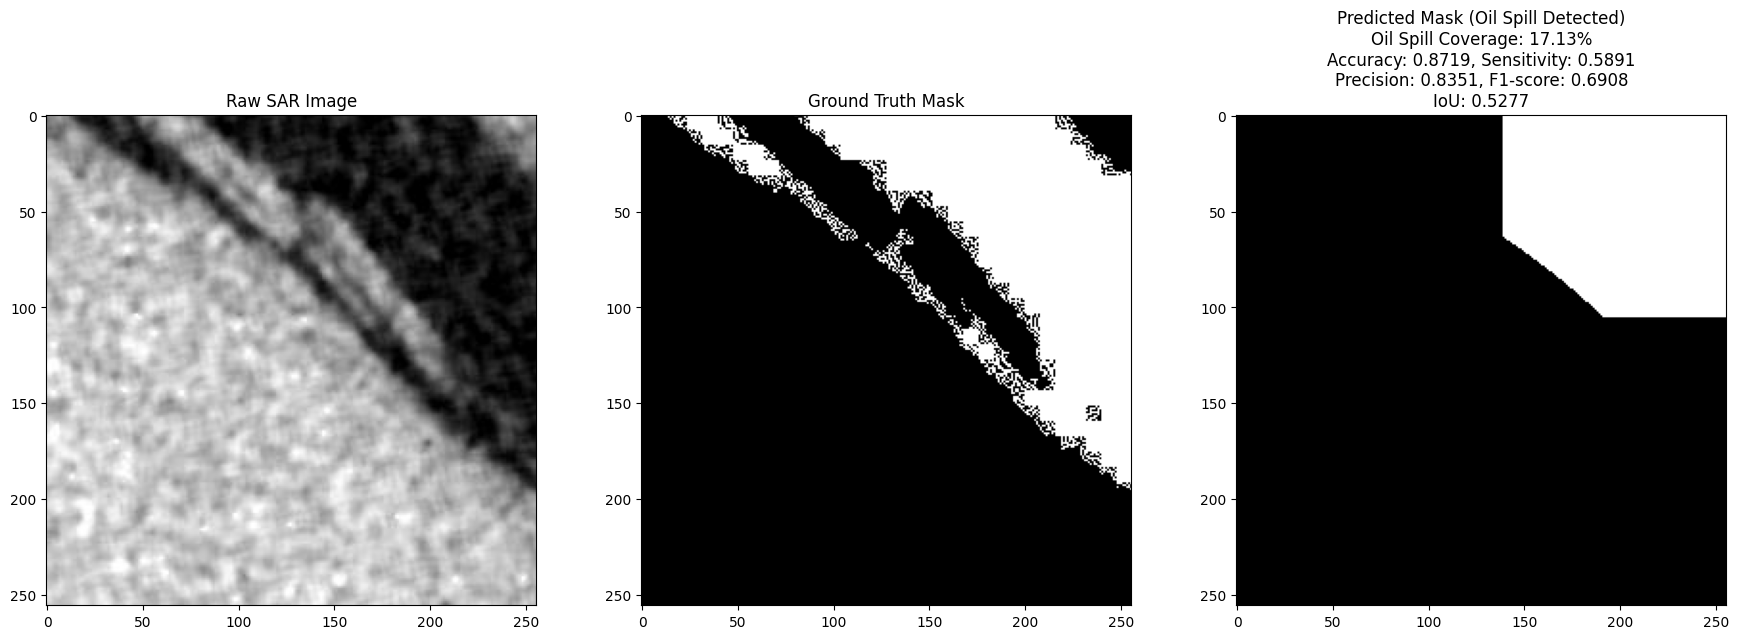

In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_model(model_path, device):
    model = DL_ViT(num_classes=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict(model, image, device):
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(image.to(device))
        predicted_mask = torch.argmax(output, dim=1).cpu().squeeze(0)  # Convert to predicted class index
    return predicted_mask

def calculate_metrics(predicted_mask, ground_truth_mask):
    predicted_mask = predicted_mask.numpy()
    ground_truth_mask = ground_truth_mask.numpy()
    
    # True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((predicted_mask == 1) & (ground_truth_mask == 1))
    TN = np.sum((predicted_mask == 0) & (ground_truth_mask == 0))
    FP = np.sum((predicted_mask == 1) & (ground_truth_mask == 0))
    FN = np.sum((predicted_mask == 0) & (ground_truth_mask == 1))
    
    # Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # Sensitivity (Recall)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # F1 Score
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    # IoU (Intersection over Union)
    intersection = np.sum((predicted_mask == 1) & (ground_truth_mask == 1))
    union = np.sum((predicted_mask == 1) | (ground_truth_mask == 1))
    iou = intersection / union if union > 0 else 0
    
    return accuracy, sensitivity, precision, f1_score, iou

def evaluate_on_single_image(model, image_path, mask_path, transform, device):
    # Load the raw SAR image
    image = Image.open(image_path).convert('RGB')
    raw_image = image.copy()  # Keep a copy for visualization
    
    # Load the ground truth mask
    mask = Image.open(mask_path).convert('L')
    
    # Transform the image and mask to tensors
    image = transform(image)
    mask = transforms.Resize((256, 256))(transforms.ToTensor()(mask)).long().squeeze(0)
    
    # Make predictions
    predicted_mask = predict(model, image, device)
    
    # Ensure the predicted mask has the same size as the ground truth mask
    predicted_mask = transforms.Resize((256, 256))(predicted_mask.unsqueeze(0)).squeeze(0)
    
    # Calculate accuracy and other metrics
    accuracy, sensitivity, precision, f1_score, iou = calculate_metrics(predicted_mask, mask)
    
    return raw_image, mask, predicted_mask, (accuracy, sensitivity, precision, f1_score, iou)

def visualize_results(raw_image, mask, predicted_mask, metrics, threshold=0.1):
    accuracy, sensitivity, precision, f1_score, iou = metrics
    
    # Calculate the percentage of pixels predicted as oil spill
    oil_spill_percentage = np.mean(predicted_mask.numpy()) * 100
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(raw_image)
    ax[0].set_title("Raw SAR Image")
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Ground Truth Mask")
    
    if oil_spill_percentage > threshold:
        ax[2].imshow(predicted_mask, cmap='gray')
        ax[2].set_title(f"Predicted Mask (Oil Spill Detected)\n"
                        f"Oil Spill Coverage: {oil_spill_percentage:.2f}%\n"
                        f"Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}\n"
                        f"Precision: {precision:.4f}, F1-score: {f1_score:.4f}\n"
                        f"IoU: {iou:.4f}")
    else:
        ax[2].imshow(np.zeros_like(predicted_mask), cmap='gray')
        ax[2].set_title("No Significant Oil Spill Detected")
    
    plt.tight_layout()
    plt.show()

def main_evaluation():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = "/kaggle/working/dl_vit_model"  # Path to your saved model
    image_path = "/kaggle/input/true-images/(11).jpg" # Replace with the actual path to the test image
    mask_path = "/kaggle/input/masked-images/(11).jpg"  # Replace with the actual path to the mask
    
    # Define transformation (same as used in training)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load the trained model
    model = load_model(model_path, device)
    
    # Evaluate on a single test image and ground truth mask
    raw_image, mask, predicted_mask, metrics = evaluate_on_single_image(model, image_path, mask_path, transform, device)
    
    # Visualize the results
    visualize_results(raw_image, mask, predicted_mask, metrics)

if __name__ == "__main__":
    main_evaluation()

With only 10 epochs and learning rate only 0.01 the accuracy stands at >87% and the mask identifucation is also there

/tmp/ipykernel_13/2595591114.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


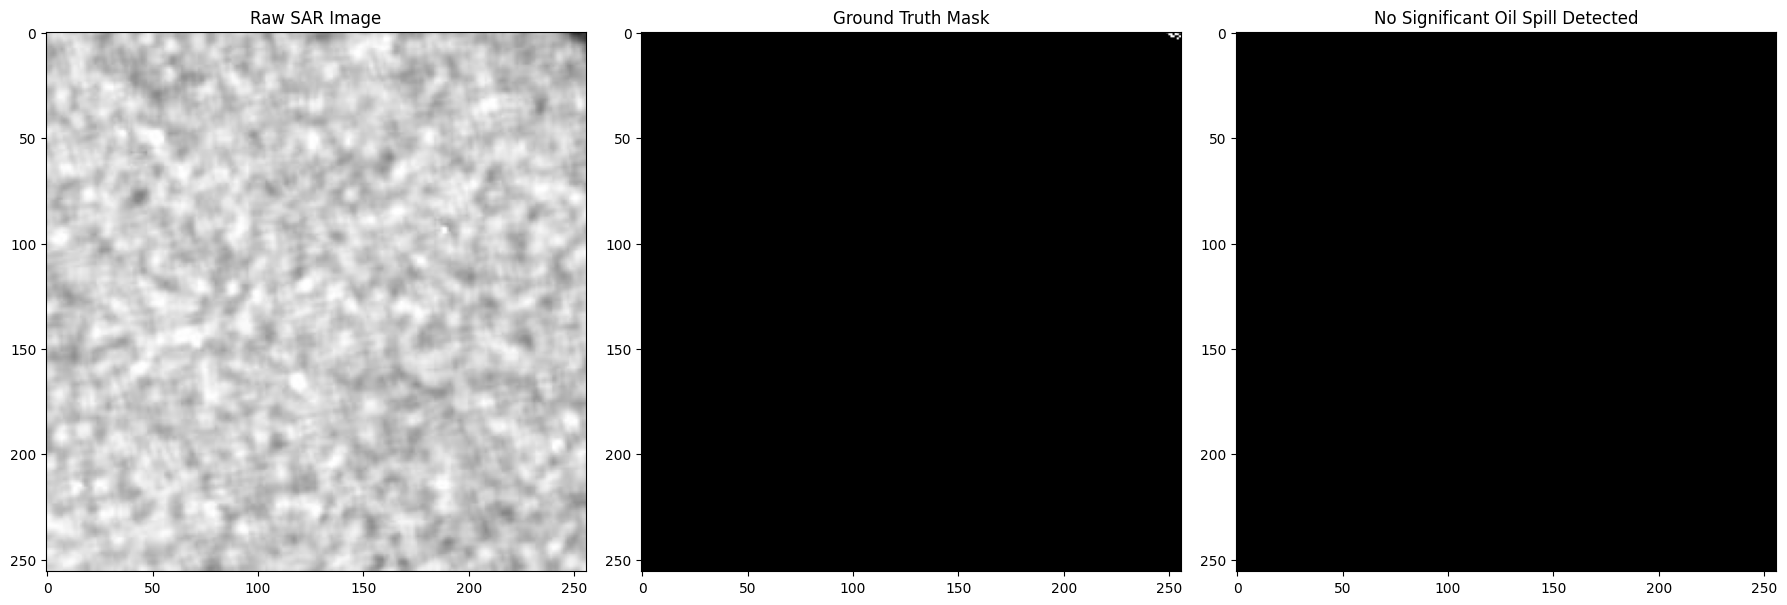

In [15]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_model(model_path, device):
    model = DL_ViT(num_classes=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict(model, image, device):
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(image.to(device))
        predicted_mask = torch.argmax(output, dim=1).cpu().squeeze(0)  # Convert to predicted class index
    return predicted_mask

def calculate_metrics(predicted_mask, ground_truth_mask):
    predicted_mask = predicted_mask.numpy()
    ground_truth_mask = ground_truth_mask.numpy()
    
    # True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((predicted_mask == 1) & (ground_truth_mask == 1))
    TN = np.sum((predicted_mask == 0) & (ground_truth_mask == 0))
    FP = np.sum((predicted_mask == 1) & (ground_truth_mask == 0))
    FN = np.sum((predicted_mask == 0) & (ground_truth_mask == 1))
    
    # Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # Sensitivity (Recall)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # F1 Score
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    # IoU (Intersection over Union)
    intersection = np.sum((predicted_mask == 1) & (ground_truth_mask == 1))
    union = np.sum((predicted_mask == 1) | (ground_truth_mask == 1))
    iou = intersection / union if union > 0 else 0
    
    return accuracy, sensitivity, precision, f1_score, iou

def evaluate_on_single_image(model, image_path, mask_path, transform, device):
    # Load the raw SAR image
    image = Image.open(image_path).convert('RGB')
    raw_image = image.copy()  # Keep a copy for visualization
    
    # Load the ground truth mask
    mask = Image.open(mask_path).convert('L')
    
    # Transform the image and mask to tensors
    image = transform(image)
    mask = transforms.Resize((256, 256))(transforms.ToTensor()(mask)).long().squeeze(0)
    
    # Make predictions
    predicted_mask = predict(model, image, device)
    
    # Ensure the predicted mask has the same size as the ground truth mask
    predicted_mask = transforms.Resize((256, 256))(predicted_mask.unsqueeze(0)).squeeze(0)
    
    # Calculate accuracy and other metrics
    accuracy, sensitivity, precision, f1_score, iou = calculate_metrics(predicted_mask, mask)
    
    return raw_image, mask, predicted_mask, (accuracy, sensitivity, precision, f1_score, iou)

def visualize_results(raw_image, mask, predicted_mask, metrics, threshold=0.1):
    accuracy, sensitivity, precision, f1_score, iou = metrics
    
    # Calculate the percentage of pixels predicted as oil spill
    oil_spill_percentage = np.mean(predicted_mask.numpy()) * 100
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(raw_image)
    ax[0].set_title("Raw SAR Image")
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Ground Truth Mask")
    
    if oil_spill_percentage > threshold:
        ax[2].imshow(predicted_mask, cmap='gray')
        ax[2].set_title(f"Predicted Mask (Oil Spill Detected)\n"
                        f"Oil Spill Coverage: {oil_spill_percentage:.2f}%\n"
                        f"Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}\n"
                        f"Precision: {precision:.4f}, F1-score: {f1_score:.4f}\n"
                        f"IoU: {iou:.4f}")
    else:
        ax[2].imshow(np.zeros_like(predicted_mask), cmap='gray')
        ax[2].set_title("No Significant Oil Spill Detected")
    
    plt.tight_layout()
    plt.show()

def main_evaluation():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = "/kaggle/working/dl_vit_model"  # Path to your saved model
    image_path = "/kaggle/input/true-images/(1).jpg" # Replace with the actual path to the test image
    mask_path = "/kaggle/input/masked-images/(1).jpg"  # Replace with the actual path to the mask
    
    # Define transformation (same as used in training)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load the trained model
    model = load_model(model_path, device)
    
    # Evaluate on a single test image and ground truth mask
    raw_image, mask, predicted_mask, metrics = evaluate_on_single_image(model, image_path, mask_path, transform, device)
    
    # Visualize the results with a threshold for oil spill detection
    threshold_percentage = 5  # Adjust this value as needed (e.g., 5% coverage)
    visualize_results(raw_image, mask, predicted_mask, metrics, threshold=threshold_percentage)

if __name__ == "__main__":
    main_evaluation()

 Its showing no oil spill detected for cases < 5% white pixels coverage